c:\Users\asknn\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Actor Loss: -1.5189, Critic Loss: 0.8982, Return: -200.0, Steps: 200
Episode 2: Actor Loss: -0.6218, Critic Loss: 0.4852, Return: -200.0, Steps: 200
Episode 3: Actor Loss: -0.7643, Critic Loss: 0.3499, Return: -200.0, Steps: 200
Episode 4: Actor Loss: -0.1363, Critic Loss: 0.0849, Return: -200.0, Steps: 200
Episode 5: Actor Loss: -0.3261, Critic Loss: 0.6955, Return: -200.0, Steps: 200
Episode 6: Actor Loss: 0.1024, Critic Loss: 0.1158, Return: -200.0, Steps: 200
Episode 7: Actor Loss: 1.0653, Critic Loss: 0.2894, Return: -200.0, Steps: 200
Episode 8: Actor Loss: 0.0392, Critic Loss: 0.0174, Return: -200.0, Steps: 200
Episode 9: Actor Loss: 0.1752, Critic Loss: 0.0112, Return: -200.0, Steps: 200
Episode 10: Actor Loss: 0.0640, Critic Loss: 0.0181, Return: -200.0, Steps: 200
Episode 11: Actor Loss: 0.0136, Critic Loss: 0.0003, Return: -200.0, Steps: 200
Episode 12: Actor Loss: 0.9304, Critic Loss: 0.3840, Return: -200.0, Steps: 200
Episode 13: Actor Loss: 0.0301, Critic Loss:

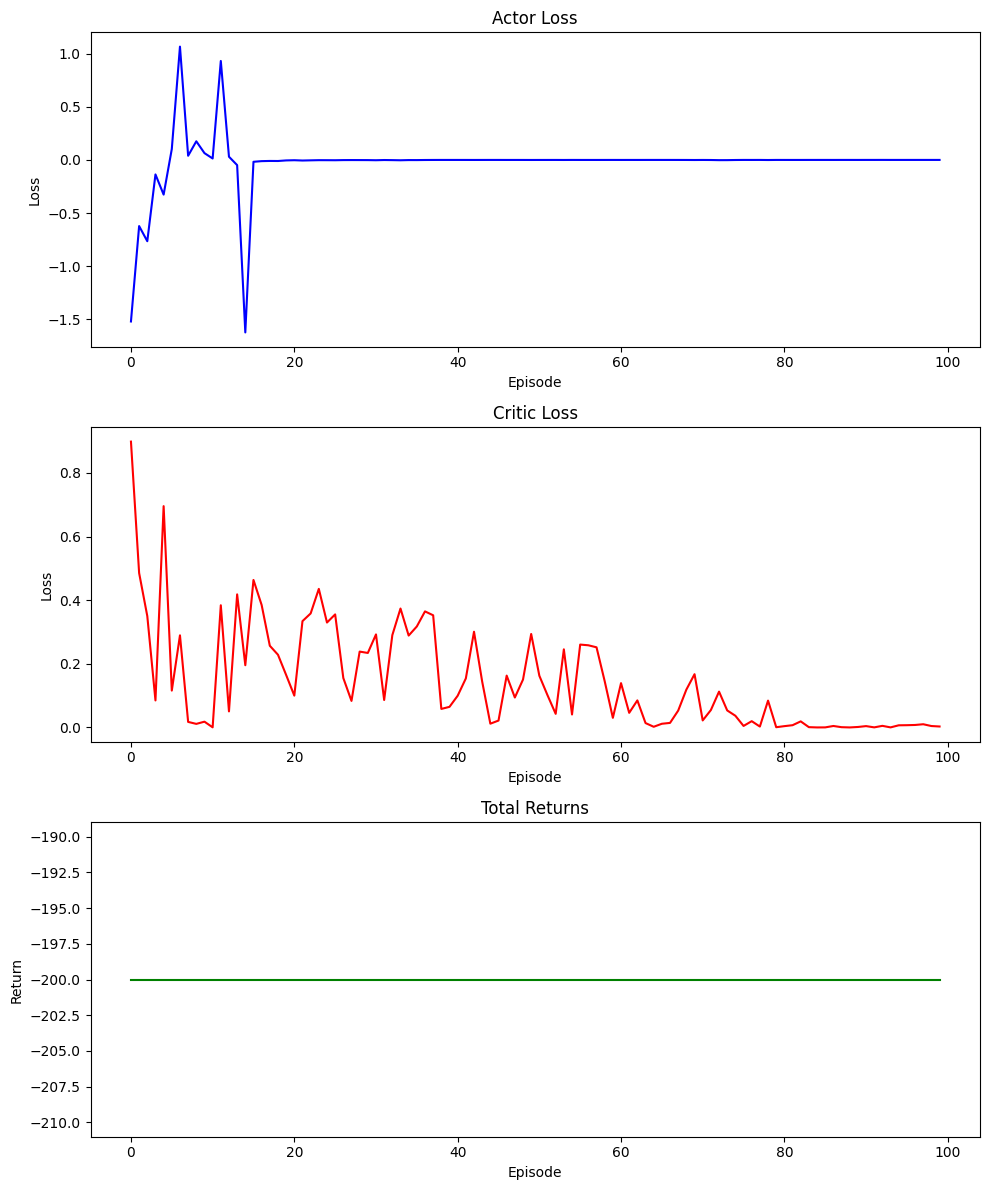

In [3]:
#A2C MOUNTAIN CAR

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from torch.distributions import Categorical
import time
import matplotlib.pyplot as plt


# Actor Network
# Çevrede hangi eylemi yapacağını öğrenmek için kullanılan ağ
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, num_actions)  # 64 nörondan çıktı olarak hareket sayısı kadar düğüm çıkar

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyon fonksiyonu kullanılır
        x = F.softmax(self.fc2(x), dim=-1)  # Eylem olasılıklarını softmax ile normalize eder dim=-1: Son boyutu ifade eder,
        return x

# Critic Network
# Durumun değerini (value function) tahmin eder
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, 1)  # Çıkışta tek bir değer üretir (durumun değeri)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyon fonksiyonu kullanılır
        x = self.fc2(x)  # Çıkış katmanı
        return x

# Actor-Critic Eğitim Döngüsü
def actor_critic(actor, critic, episodes, max_steps=200, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    # Actor ve Critic için optimizasyon algoritmalarını tanımlıyoruz
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    # Eğitim istatistiklerini kaydetmek için bir sözlük oluşturuyoruz
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    # MountainCar-v0 ortamını oluşturuyoruz
    env = gym.make('MountainCar-v0')
    input_size = env.observation_space.shape[0]  # Ortamın durum (state) boyutu
    num_actions = env.action_space.n  # Eylem (action) sayısı

    for episode in range(1, episodes + 1):  # Her bölüm için döngü başlatılır
        state = env.reset()[0]  # Başlangıç durumu alınıyor
        ep_return = 0  # Bu bölümdeki toplam ödül
        done = False  # Bölümün bitiş durumu
        step_count = 0  # Adım sayacı

        while not done and step_count < max_steps:  # Bölüm tamamlanmadığı sürece çalışır
            state_tensor = torch.FloatTensor(state)  # Durumu PyTorch tensörüne çeviriyoruz

            # Actor ağından eylem olasılıklarını alıyoruz
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)  # Olasılık dağılımını oluşturuyoruz
            action = dist.sample()  # Dağılımdan bir eylem seçiyoruz

            # Seçilen eylemi çevrede gerçekleştiriyoruz
            next_state, reward, done, _, _ = env.step(action.item())

            # Critic ağını kullanarak durumların değerlerini hesaplıyoruz
            value = critic(state_tensor)  # Mevcut durumun değeri
            next_value = critic(torch.FloatTensor(next_state))  # Sonraki durumun değeri

            # TD Hedefini ve avantajı (advantage) hesaplıyoruz
            td_target = reward + gamma * next_value * (1 - done)  # TD Hedefi
            advantage = td_target - value  # Avantaj

            # Critic ağını güncellemek için kayıp fonksiyonu ve optimizasyon
            critic_loss = F.mse_loss(value, td_target.detach())  # MSE kayıp fonksiyonu f pytorch
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()

            # Actor ağını güncellemek için kayıp fonksiyonu ve optimizasyon
            log_prob = dist.log_prob(action)  # Seçilen eylemin logaritmik olasılığı
            actor_loss = -log_prob * advantage.detach()  # Politika gradyan kaybı
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()

            # Durumu ve ödülleri güncelliyoruz
            state = next_state  # Sonraki durum, mevcut durum olarak atanır
            ep_return += reward  # Ödül toplanır
            step_count += 1  # Adım sayacı artırılır

        # Her bölüm için istatistikleri kaydediyoruz
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)

        # Bölüm istatistiklerini ekrana yazdırıyoruz
        print(f"Episode {episode}: Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")

    env.close()  # Ortamı kapatıyoruz
    return stats  # Eğitim istatistiklerini döndürüyoruz

# Actor ve Critic modellerini oluşturuyoruz
actor = Actor(input_size=2, num_actions=3)  # MountainCar'da 2 durum değişkeni ve 3 eylem bulunur
critic = Critic(input_size=2)

# Modeli eğitmek için aktör-eleştirmen algoritmasını çağırıyoruz
stats = actor_critic(actor, critic, episodes=100)

actor_loss = stats['Actor Loss']  # Actor kaybı
critic_loss = stats['Critic Loss']  # Critic kaybı
returns = stats['Returns']  # Toplam ödül

# Eğitim istatistiklerini çizmek için üç farklı grafiği alt alta koyacağız

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# 1. Grafik: Actor Loss
axs[0].plot(actor_loss, color='blue')
axs[0].set_title('Actor Loss')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Loss')

# 2. Grafik: Critic Loss
axs[1].plot(critic_loss, color='red')
axs[1].set_title('Critic Loss')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Loss')

# 3. Grafik: Total Returns (Toplam Ödüller)
axs[2].plot(returns, color='green')
axs[2].set_title('Total Returns')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Return')

# Grafiklerin yerleşimini iyileştiriyoruz
plt.tight_layout()

# Grafiklerin gösterilmesi
plt.show()

Episode 1: Actor Loss: 0.2812, Critic Loss: 0.2609, Return: -1.0, Steps: 2
Episode 2: Actor Loss: 0.4709, Critic Loss: 9.7688, Return: 1.0, Steps: 3
Episode 3: Actor Loss: 0.1740, Critic Loss: 4.4019, Return: 0.0, Steps: 1
Episode 4: Actor Loss: 0.0592, Critic Loss: 0.6889, Return: -1.0, Steps: 1
Episode 5: Actor Loss: 0.0085, Critic Loss: 0.0580, Return: -1.0, Steps: 1
Episode 6: Actor Loss: 0.0594, Critic Loss: 7.2426, Return: 1.0, Steps: 1
Episode 7: Actor Loss: 0.0005, Critic Loss: 0.0004, Return: -1.0, Steps: 1
Episode 8: Actor Loss: -0.0667, Critic Loss: 0.3204, Return: -1.0, Steps: 1
Episode 9: Actor Loss: -0.0080, Critic Loss: 0.0984, Return: -1.0, Steps: 1
Episode 10: Actor Loss: -0.0048, Critic Loss: 0.1540, Return: -1.0, Steps: 1
Episode 11: Actor Loss: -0.0081, Critic Loss: 0.1235, Return: -1.0, Steps: 1
Episode 12: Actor Loss: 0.0534, Critic Loss: 1.8292, Return: 1.0, Steps: 1
Episode 13: Actor Loss: 0.0571, Critic Loss: 1.7558, Return: 1.0, Steps: 1
Episode 14: Actor Loss

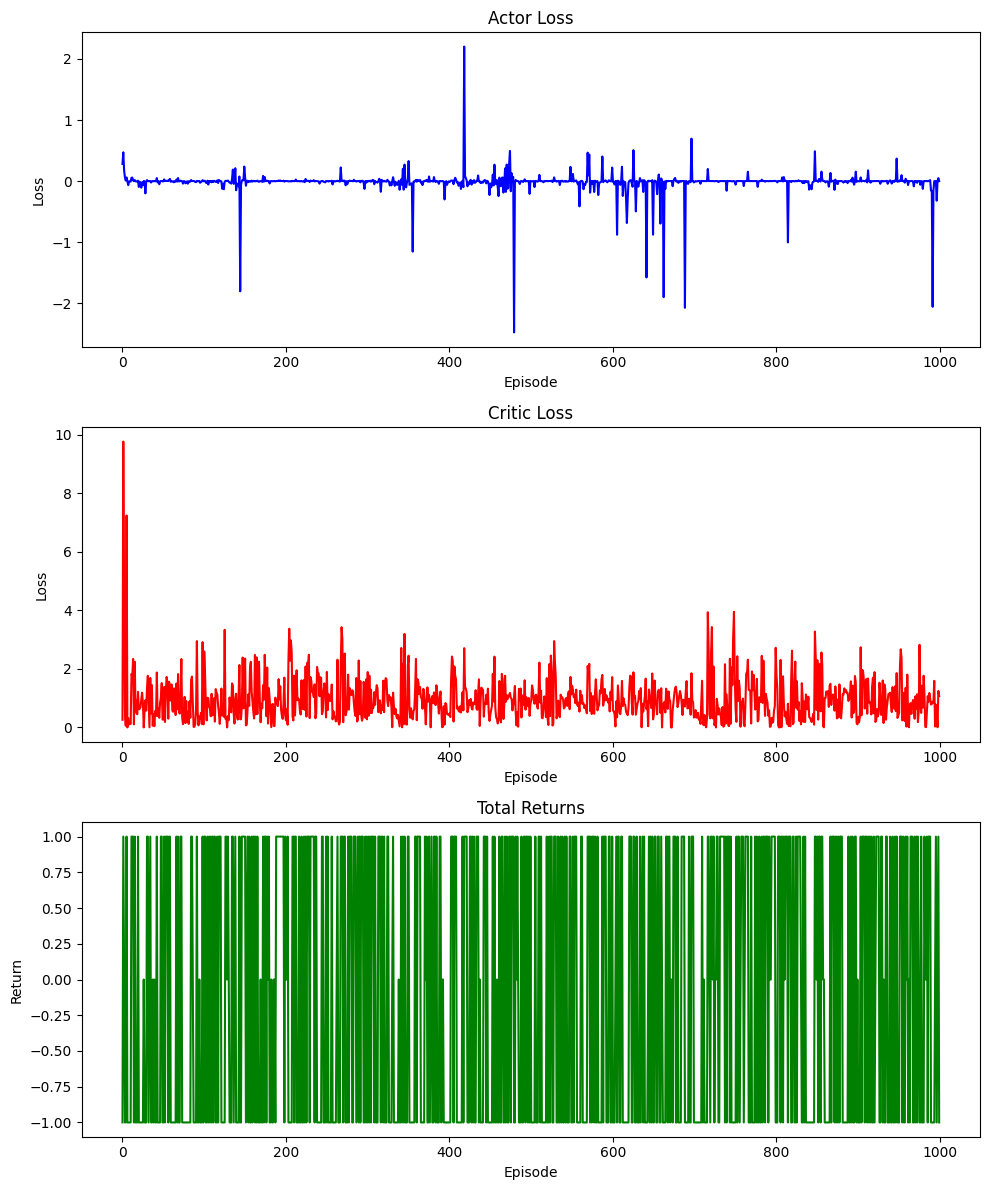

In [5]:
#A2C BLACKJACK ALGORİTMASI

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt


# Actor Network
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, num_actions)  # Çıkışta num_actions kadar düğüm çıkar (Blackjack: 2 eylem)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyonu
        x = F.softmax(self.fc2(x), dim=-1)  # Çıkışta softmax ile eylem olasılıkları
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, 1)  # Çıkışta tek bir değer üretir (durumun değeri)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyonu
        x = self.fc2(x)  # Çıkış katmanı (durumun değeri)
        return x

# Actor-Critic Algorithm
def actor_critic(actor, critic, episodes, max_steps=2000, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    # Optimizerlar tanımlanıyor
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    # İstatistikleri kaydetmek için bir sözlük
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    # Blackjack ortamını oluşturuyoruz
    env = gym.make('Blackjack-v1')  # OpenAI Gym'in Blackjack ortamı
    input_size = 3  # Blackjack'de oyuncunun toplamı, krupiyenin gösterdiği kart, kullanılabilir as
    num_actions = env.action_space.n  # Eylemler: 2 (hit: 0, stand: 1)

    for episode in range(1, episodes + 1):  # Her bölüm için döngü başlatılır
        state = env.reset()  # Ortam sıfırlanır ve başlangıç durumu alınır
        state = state[0]  # Durum bir tuple olabilir; ilk öğe alınır
        ep_return = 0  # Bu bölümdeki toplam ödül
        done = False  # Bölüm bitiş durumu
        step_count = 0  # Adım sayacı

        while not done and step_count < max_steps:  # Bölüm tamamlanmadığı sürece çalışır
            state_tensor = torch.FloatTensor(state)  # Durumu PyTorch tensörüne çeviriyoruz
            
            # Actor ağı duruma göre eylem olasılıklarını üretir
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)  # Olasılık dağılımını oluşturur
            action = dist.sample()  # Dağılımdan bir eylem seçer
            
            # Eylemi çevrede gerçekleştirir ve sonuçları alır
            next_state, reward, done, _, _ = env.step(action.item())
            
            # Critic ağı duruma göre değer tahmini yapar
            value = critic(state_tensor)  # Mevcut durumun değeri
            next_value = critic(torch.FloatTensor(next_state))  # Sonraki durumun değeri
            
            # TD hedefi ve avantajı hesaplanır
            td_target = reward + gamma * next_value * (1 - done)  # TD Hedefi
            advantage = td_target - value  # Avantaj (TD Hedefi - Tahmini Değer)
            
            # Critic güncellemesi (MSE kaybıyla)
            critic_loss = F.mse_loss(value, td_target.detach())  # MSE kaybı
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()
            
            # Actor güncellemesi (Politika gradyanı ile)
            log_prob = dist.log_prob(action)  # Seçilen eylemin logaritmik olasılığı
            actor_loss = -log_prob * advantage.detach()  # Politika gradyan kaybı
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()
            
            # Durum, ödül ve adım sayacı güncellenir
            state = next_state
            ep_return += reward
            step_count += 1

        # Bölüm istatistikleri kaydedilir
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)

        # Bölüm sonuçlarını ekrana yazdırır
        print(f"Episode {episode}: Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")

    env.close()  # Ortam kapatılır
    return stats  # Eğitim istatistikleri döndürülür

# Ağları tanımla ve eğit
actor = Actor(input_size=3, num_actions=2)  # Blackjack: 3 durum bilgisi ve 2 eylem
critic = Critic(input_size=3)  # Critic de aynı durum bilgisine bağlıdır
stats = actor_critic(actor, critic, episodes=1000)  # 1000 bölüm boyunca eğitimi başlat
average_reward = sum(stats['Returns']) / len(stats['Returns'])  # Ortalama ödül hesapla
print(f"Ortalama Ödül (Average Reward): {average_reward:.2f}")  # Ortalama ödülü yazdır

# Eğitimdeki istatistikleri içeren veriler (bunu 'actor_critic' fonksiyonundan aldığınız 'stats' değişkeniyle elde edersiniz)
actor_loss = stats['Actor Loss']  # Actor kaybı
critic_loss = stats['Critic Loss']  # Critic kaybı
returns = stats['Returns']  # Toplam ödül

# Eğitim istatistiklerini çizmek için üç farklı grafiği alt alta koyacağız

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# 1. Grafik: Actor Loss
axs[0].plot(actor_loss, color='blue')
axs[0].set_title('Actor Loss')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Loss')

# 2. Grafik: Critic Loss
axs[1].plot(critic_loss, color='red')
axs[1].set_title('Critic Loss')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Loss')

# 3. Grafik: Total Returns (Toplam Ödüller)
axs[2].plot(returns, color='green')
axs[2].set_title('Total Returns')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Return')

# Grafiklerin yerleşimini iyileştiriyoruz
plt.tight_layout()

# Grafiklerin gösterilmesi
plt.show()